# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [39]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [12]:
# Your code here
# Part 1: Implementing AdaBoost
class AdaBoostCustom:
    def __init__(self, T):
        self.T = T
        self.alphas = []
        self.models = []
        # Note: You may add more attributes

    def fit(self, X, y):
        # Your code here
        pass
    
    def predict(self, X):  
        # Your code here
        pass

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

In [23]:
# Generate a dataset with the same parameters as IRIS dataset

X, y = make_classification(n_samples = 1000, n_features=4, n_informative=2, n_classes=3, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [29]:
X.shape

(1000, 4)

In [7]:
y.shape

(1000,)

In [57]:
total_classes = len(np.unique(y))
print(f"There are {total_classes} classes")

There are 3 classes


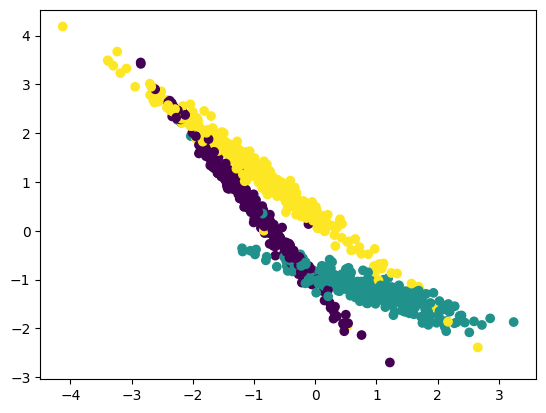

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y)

# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

Total accuracy: 0.8333333333333334


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


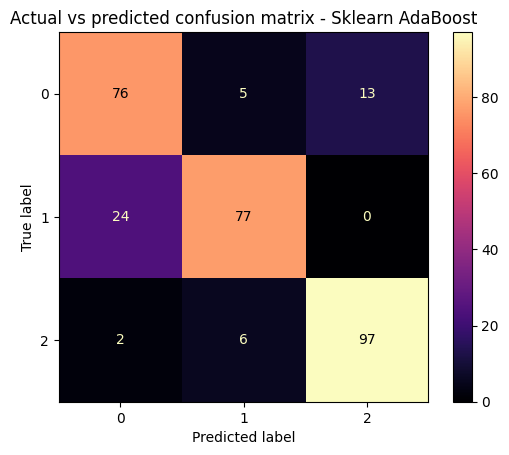

/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (0, 1) has a score of 0.6833333333333333


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (0, 2) has a score of 0.81


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (0, 3) has a score of 0.6366666666666667


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (1, 2) has a score of 0.8633333333333333


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (1, 3) has a score of 0.6733333333333333


/Users/scohen6/projects/idc_msc/advanced-ml/exc1/venv/lib/python3.13/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost with 10 estimators with features (2, 3) has a score of 0.8566666666666667


/var/folders/04/b5_9lzx5797dzscx6rwj46k80000gr/T/ipykernel_44636/2888187678.py:103: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(h_pad=1, w_pad=1, pad=10)


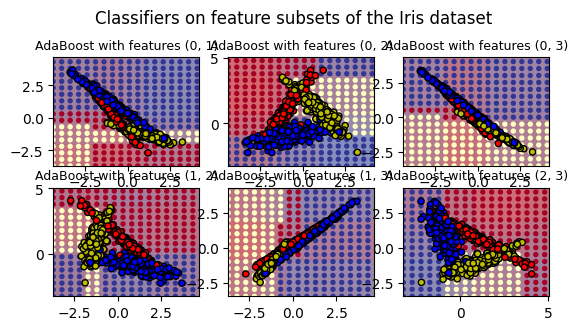

In [69]:
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Train Adaboost Classifer
sklearn_res = sklearn_model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = sklearn_res.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Total accuracy:",accuracy_score(y_test, y_pred))

matrix_plot = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix_plot)
cm_display.plot(cmap="magma")
plt.title(
    "Actual vs predicted confusion matrix - Sklearn AdaBoost"
)
plt.grid(False)
plt.show()

plot_idx = 1
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
cmap = plt.cm.RdYlBu

list_range = range(len(X_train[1]))
all_pairs = [(a, b) for idx, a in enumerate(list_range) for b in list_range[idx + 1:]]
for pair in all_pairs:
    X_train_pair = X_train[:,pair]
    X_test_pair = X_test[:,pair]
    
    # Train
    sklearn_res = sklearn_model.fit(X_train_pair, y_train)
    #Predict the response for test dataset
    y_pred = sklearn_res.predict(X_test_pair)

    acc = accuracy_score(y_test, y_pred)
    # Create a title for each column and the console by using str() and
    # slicing away useless parts of the string
    model_title = str(type(sklearn_model)).split(".")[-1][:-2][: -len("Classifier")]

    model_details = model_title
    if hasattr(sklearn_model, "estimators_"):
        model_details += " with {} estimators".format(len(sklearn_model.estimators_))
    print(model_details + " with features", pair, "has a score of", acc)

    plt.subplot(3, 3, plot_idx)
    plt.title(f"{model_title} with features {pair}", fontsize=9)

    # Now plot the decision boundary using a fine mesh as input to a
    # filled contour plot
    x_min, x_max = X_train_pair[:, 0].min() - 1, X_train_pair[:, 0].max() + 1
    y_min, y_max = X_train_pair[:, 1].min() - 1, X_train_pair[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    # Choose alpha blend level with respect to the number
    # of estimators
    # that are in use (noting that AdaBoost can use fewer estimators
    # than its maximum if it achieves a good enough fit early on)
    estimator_alpha = 1.0 / len(sklearn_model.estimators_)
    for tree in sklearn_model.estimators_:
        Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

    # Build a coarser grid to plot a set of ensemble classifications
    # to show how these are different to what we see in the decision
    # surfaces. These points are regularly space and do not have a
    # black outline
    xx_coarser, yy_coarser = np.meshgrid(
        np.arange(x_min, x_max, plot_step_coarser),
        np.arange(y_min, y_max, plot_step_coarser),
    )
    Z_points_coarser = sklearn_res.predict(
        np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
    ).reshape(xx_coarser.shape)
    cs_points = plt.scatter(
        xx_coarser,
        yy_coarser,
        s=15,
        c=Z_points_coarser,
        cmap=cmap,
        edgecolors="none",
    )

    # Plot the training points, these are clustered together and have a
    # black outline
    plt.scatter(
        X_train_pair[:, 0],
        X_train_pair[:, 1],
        c=y_train,
        cmap=ListedColormap(["r", "y", "b"]),
        edgecolor="k",
        s=20,
    )
    plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=1, w_pad=1, pad=10)
plt.show()

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [ ]:
# Generate additional data sets

# Split data sets

In [ ]:
# Visualize data

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [ ]:
# Set up models 

In [ ]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 